In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget
import torch
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import imageio

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class NerfModel(nn.Module):
    def __init__(self, embedding_dim_pos=10, embedding_dim_direction=4, hidden_dim=128):
        super(NerfModel, self).__init__()

        self.block1 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # density estimation
        self.block2 = nn.Sequential(
            nn.Linear(embedding_dim_pos * 6 + hidden_dim + 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim + 1),
        )
        # color estimation
        self.block3 = nn.Sequential(
            nn.Linear(embedding_dim_direction * 6 + hidden_dim + 3, hidden_dim // 2),
            nn.ReLU(),
        )
        self.block4 = nn.Sequential(
            nn.Linear(hidden_dim // 2, 3),
            nn.Sigmoid(),
        )

        self.embedding_dim_pos = embedding_dim_pos
        self.embedding_dim_direction = embedding_dim_direction
        self.relu = nn.ReLU()

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2**j * x))
            out.append(torch.cos(2**j * x))
        return torch.cat(out, dim=1)

    def forward(self, o, d):
        emb_x = self.positional_encoding(
            o, self.embedding_dim_pos
        )  # emb_x: [batch_size, embedding_dim_pos * 6]
        emb_d = self.positional_encoding(
            d, self.embedding_dim_direction
        )  # emb_d: [batch_size, embedding_dim_direction * 6]
        h = self.block1(emb_x)  # h: [batch_size, hidden_dim]
        tmp = self.block2(
            torch.cat((h, emb_x), dim=1)
        )  # tmp: [batch_size, hidden_dim + 1]
        h, sigma = (
            tmp[:, :-1],
            self.relu(tmp[:, -1]),
        )  # h: [batch_size, hidden_dim], sigma: [batch_size]
        h = self.block3(
            torch.cat((h, emb_d), dim=1)
        )  # h: [batch_size, hidden_dim // 2]
        c = self.block4(h)  # c: [batch_size, 3]
        return c, sigma

In [5]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], axis=-1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], axis=-1)
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103
(100, 100, 3) (100, 100, 3)


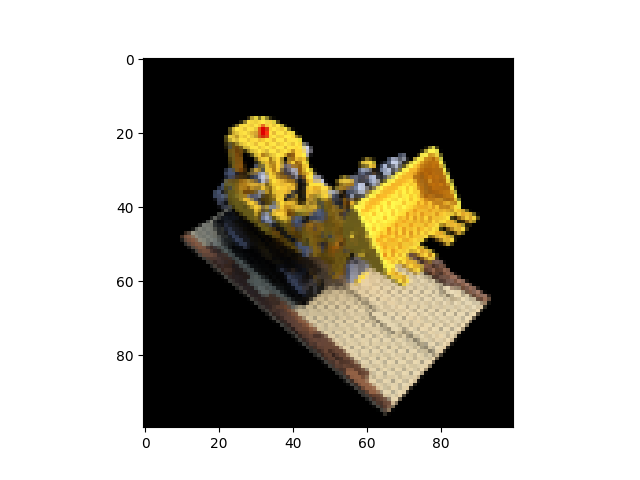

In [6]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
test_images = images[100:,:, :,:3].copy()
test_poses = poses[100:].copy()
images = images[:100,:, :,:3]
poses = poses[:100]
rays_o, rays_d = get_rays(H, W, focal, testpose)
print(rays_o.shape, rays_d.shape)

training_dataset = np.zeros((images.shape[0] * H * W, 9))
for i in range(images.shape[0] - 1):
    rays_o, rays_d = get_rays(H, W, focal, poses[i])
    training_dataset[i * H * W : (i + 1) * H * W, :3] = rays_o.reshape(-1, 3)
    training_dataset[i * H * W : (i + 1) * H * W, 3:6] = rays_d.reshape(-1, 3)
    training_dataset[i * H * W : (i + 1) * H * W, 6:9] = images[i].reshape(-1, 3)

testing_dataset = np.zeros((test_images.shape[0] * H * W, 9))
for i in range(test_images.shape[0] - 1):
    rays_o, rays_d = get_rays(H, W, focal, test_poses[i])
    testing_dataset[i * H * W : (i + 1) * H * W, :3] = rays_o.reshape(-1, 3)
    testing_dataset[i * H * W : (i + 1) * H * W, 3:6] = rays_d.reshape(-1, 3)
    testing_dataset[i * H * W : (i + 1) * H * W, 6:9] = test_images[i].reshape(-1, 3)

training_dataset = torch.from_numpy(training_dataset.copy()).float()
testing_dataset = torch.from_numpy(testing_dataset.copy()).float()

nb_training_samples = images.shape[0]
nb_testing_samples = test_images.shape[0]
plt.imshow(testimg)
plt.show()

In [7]:
def compute_accumulated_transmittance(alphas):
    accumulated_transmittance = torch.cumprod(alphas, 1)
    return torch.cat(
        (
            torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device),
            accumulated_transmittance[:, :-1],
        ),
        dim=-1,
    )


def render_rays(nerf_model, ray_origins, ray_directions, hn=2, hf=6, nb_bins=192):
    t = torch.linspace(hn, hf, nb_bins, device=device).expand(
        ray_origins.shape[0], nb_bins
    )
    # Perturb sampling along each ray.
    mid = (t[:, :-1] + t[:, 1:]) / 2.0
    lower = torch.cat((t[:, :1], mid), -1)
    upper = torch.cat((mid, t[:, -1:]), -1)
    u = torch.rand(t.shape, device=device)
    t = lower + (upper - lower) * u  # [batch_size, nb_bins]
    delta = torch.cat(
        (
            t[:, 1:] - t[:, :-1],
            torch.tensor([1e10], device=device).expand(ray_origins.shape[0], 1),
        ),
        -1,
    )

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(
        1
    )  # [batch_size, nb_bins, 3]
    # Expand the ray_directions tensor to match the shape of x
    ray_directions = ray_directions.expand(
        nb_bins, ray_directions.shape[0], 3
    ).transpose(0, 1)

    colors, sigma = nerf_model(x.reshape(-1, 3), ray_directions.reshape(-1, 3))
    colors = colors.reshape(x.shape)
    sigma = sigma.reshape(x.shape[:-1])

    alpha = 1 - torch.exp(-sigma * delta)  # [batch_size, nb_bins]
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(
        2
    ) * alpha.unsqueeze(2)
    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * colors).sum(dim=1)
    # Regularization for white background
    # weight_sum = weights.sum(-1).sum(-1)  
    # return c + 1 - weight_sum.unsqueeze(-1)
    return c

In [8]:
def test(model, hn, hf, dataset, epoch, chunk_size=10, img_index=0, nb_bins=64, H=100, W=100):
    """
    Args:
        hn: near plane distance
        hf: far plane distance
        dataset: dataset to render
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        img_index (int, optional): image index to render. Defaults to 0.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 192.
        H (int, optional): image height. Defaults to 400.
        W (int, optional): image width. Defaults to 400.

    Returns:
        None: None
    """
    with torch.no_grad():
        ray_origins = dataset[img_index * H * W : (img_index + 1) * H * W, :3]
        ray_directions = dataset[img_index * H * W : (img_index + 1) * H * W, 3:6]
        ground_truth_px_values = dataset[img_index * H * W : (img_index + 1) * H * W, 6:]

        data = []  # list of regenerated pixel values
        img_loss = 0
        for i in range(int(np.ceil(H / chunk_size))):  # iterate over chunks
            # Get chunk of rays
            ray_origins_ = ray_origins[i * W * chunk_size : (i + 1) * W * chunk_size].to(
                device
            )
            ray_directions_ = ray_directions[
                i * W * chunk_size : (i + 1) * W * chunk_size
            ].to(device)
            ground_truth_px_values_ = ground_truth_px_values[
                i * W * chunk_size : (i + 1) * W * chunk_size
            ].to(device)
            regenerated_px_values = render_rays(
                model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins
            )
            data.append(regenerated_px_values)
            img_loss += ((ground_truth_px_values_ - regenerated_px_values) ** 2).sum()
        img_loss /= int(np.ceil(H / chunk_size))
        img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

        return img_loss, img

In [9]:
def train(
    nerf_model,
    optimizer,
    scheduler,
    data_loader,
    fig,ax,
    device="cpu",
    hn=0,
    hf=1,
    nb_epochs=int(1e5),
    nb_bins=64,
    H=100,
    W=100,
):
    training_loss = []
    log_interval = 100
    curr_step = 0
    for epoch in tqdm(range(nb_epochs)):
        pbar = tqdm(data_loader)
        for batch_idx, batch in enumerate(pbar):
            ray_origins = batch[:, :3].to(device)
            ray_directions = batch[:, 3:6].to(device)
            ground_truth_px_values = batch[:, 6:].to(device)

            regenerated_px_values = render_rays(
                nerf_model, ray_origins, ray_directions, hn=hn, hf=hf, nb_bins=nb_bins
            )
            loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            curr_step += 1
            if batch_idx % log_interval == 0:
                pbar.set_description(f"Step: {batch_idx}, Loss: {loss.item()}")
                _, test_img = test(
                    nerf_model,
                    hn,
                    hf,
                    training_dataset,
                    epoch,
                    chunk_size=20,
                    img_index=5,
                    nb_bins=nb_bins,
                    H=H,
                    W=W,
                )
                # Plot the training loss
                ax[0].clear()
                ax[0].plot(training_loss, label="Training Loss")
                ax[0].set_yscale("log")
                ax[0].set_xlabel("Step")
                ax[0].set_ylabel("Loss")
                ax[1].imshow(test_img)
                ax[1].set_title("Test Image")
                fig.canvas.draw()

        scheduler.step()
        test_loss = 0
        for img_index in tqdm(range(nb_testing_samples)):
            test_img_loss, _ = test(
                nerf_model,
                hn,
                hf,
                testing_dataset,
                epoch,
                chunk_size=20,
                img_index=img_index,
                nb_bins=nb_bins,
                H=H,
                W=W,
            )
            test_loss += test_img_loss
        test_loss /= nb_testing_samples
        test_loss = test_loss.item()
        print(f"--- Epoch: {epoch}, Test Loss: {test_loss}")
        ax[0].plot(
            [batch_idx + epoch * len(data_loader)] * 2,
            [test_loss, test_loss],
            label="Test Loss",
        )
        ax[0].legend()
        fig.canvas.draw()
    fig.savefig("./training_loss.png")
    plt.close(fig)

    return training_loss

In [10]:
model = NerfModel(hidden_dim=256).to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    model_optimizer, milestones=[2, 4, 8], gamma=0.5
)
data_loader = DataLoader(
    training_dataset, batch_size=128, shuffle=True, num_workers=4
)

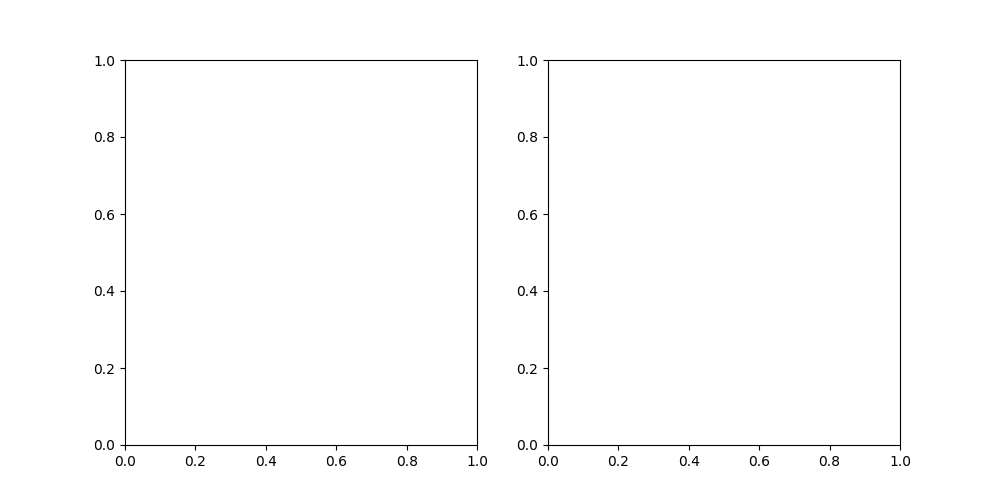

No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm: e9bff8a487e04f3994bcab39d840647d
No such comm:

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.show()

In [12]:
train(
    model,
    model_optimizer,
    scheduler,
    data_loader,
    fig,ax,    
    nb_epochs=2,
    device=device,
    hn=2,
    hf=6,
    nb_bins=64,
    H=100,
    W=100,
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7813 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch: 0, Test Loss: 19.60014533996582


  0%|          | 0/7813 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

--- Epoch: 1, Test Loss: 16.95447540283203


[68.90007019042969,
 67.42388153076172,
 63.38154220581055,
 65.2369613647461,
 63.51388168334961,
 56.371795654296875,
 54.374595642089844,
 57.52854919433594,
 49.330474853515625,
 44.65753936767578,
 40.36423873901367,
 36.450904846191406,
 27.09798240661621,
 31.711551666259766,
 28.292409896850586,
 31.59160614013672,
 20.687973022460938,
 29.28249740600586,
 31.69384765625,
 31.510910034179688,
 28.844282150268555,
 26.103036880493164,
 25.925861358642578,
 17.909997940063477,
 19.8126163482666,
 21.546367645263672,
 22.871707916259766,
 22.656829833984375,
 24.201141357421875,
 18.414953231811523,
 26.769989013671875,
 18.689495086669922,
 23.58316993713379,
 18.936363220214844,
 18.855724334716797,
 17.58277130126953,
 27.353124618530273,
 21.54476547241211,
 20.34549331665039,
 21.364276885986328,
 17.472869873046875,
 23.208219528198242,
 25.549713134765625,
 25.818187713623047,
 22.730106353759766,
 21.398725509643555,
 20.669048309326172,
 21.77726936340332,
 19.72584152221

In [13]:
def gen_image(model, ray_origins, ray_directions, hn, hf, chunk_size=10, nb_bins=64, H=100, W=100):
    """
    Args:
        model: trained model
        hn: near plane distance
        hf: far plane distance
        ray_origins: ray origins
        ray_directions: ray directions
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        nb_bins (int, optional): number of bins for density estimation. Defaults to 64.
        H (int, optional): image height. Defaults to 100.
        W (int, optional): image width. Defaults to 100.

    Returns:
        None: None
    """
    with torch.no_grad():
        data = []  # list of regenerated pixel values
        for i in range(int(np.ceil(H / chunk_size))):  # iterate over chunks
            # Get chunk of rays
            ray_origins_ = ray_origins[i * W * chunk_size : (i + 1) * W * chunk_size].to(
                device
            )
            ray_directions_ = ray_directions[
                i * W * chunk_size : (i + 1) * W * chunk_size
            ].to(device)

            regenerated_px_values = render_rays(
                model, ray_origins_, ray_directions_, hn=hn, hf=hf, nb_bins=nb_bins
            )
            data.append(regenerated_px_values)
        img = torch.cat(data).data.cpu().numpy().reshape(H, W, 3)

        return img

In [14]:
from ipywidgets import interactive, widgets


def trans_t(t):
    return np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]], dtype=np.float32)

def rot_phi(phi):
    return np.array([[1, 0, 0, 0], [0, np.cos(phi), -np.sin(phi), 0], [0, np.sin(phi), np.cos(phi), 0], [0, 0, 0, 1]], dtype=np.float32)

def rot_theta(th):
    return np.array([[np.cos(th), 0, -np.sin(th), 0], [0, 1, 0, 0], [np.sin(th), 0, np.cos(th), 0], [0, 0, 0, 1]], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rays_o = torch.from_numpy(rays_o.reshape(-1, 3)).to(device).float()
    rays_d = torch.from_numpy(rays_d.reshape(-1, 3)).to(device).float()
    rgb = gen_image(model, rays_o, rays_d, hn=2., hf=6., nb_bins=64)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

def sldr(v, mi, ma):
    return widgets.FloatSlider(value=v, min=mi, max=ma, step=0.01)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [15]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rays_o = torch.from_numpy(rays_o.reshape(-1, 3)).to(device).float()
    rays_d = torch.from_numpy(rays_d.reshape(-1, 3)).to(device).float()
    rgb = gen_image(model, rays_o, rays_d, hn=2., hf=6., nb_bins=64)
    
    # Upsample frames to 350x350
    f = torch.from_numpy((255*np.clip(rgb,0,1)).astype(np.uint8)).permute(2, 0, 1).unsqueeze(0)
    f = nn.functional.interpolate(f, size=(350, 350), mode="nearest")
    frames.append(f[0].permute(1, 2, 0).numpy().astype(np.uint8))


f = './video.gif'
imageio.mimwrite(f, frames, fps=30, quality=7)

  0%|          | 0/120 [00:00<?, ?it/s]